In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [99]:
start_date = '2021-01-01'
end_date = '2023-12-31'

In [122]:
stocks = ['VOO']

In [123]:
data = yf.download(stocks, start=start_date, end=end_date)
prices = data['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [124]:
moving_averages = prices.rolling(window=200, min_periods=1).mean()

In [125]:
def buy_the_dip(prices, moving_averages, drop_threshold=0.10, profit_threshold=0.05, stop_loss_threshold=0.20):
    positions = {stock: {'holding': False, 'buy_price': 0} for stock in prices.columns}
    cash = 100000  # Starting capital
    portfolio_value = []
    holdings = {stock: 0 for stock in prices.columns}
    dates = prices.index

    for date in dates:
        for stock in prices.columns:
            price = prices.loc[date, stock]
            ma = moving_averages.loc[date, stock]
            if pd.notna(price) and pd.notna(ma):
                drop = (ma - price) / ma
            
                if not positions[stock]['holding'] and drop >= drop_threshold:
                    # Buy signal
                    amount_to_invest = cash * 0.2
                    shares_to_buy = amount_to_invest // price
                    if shares_to_buy > 0:
                        cash -= shares_to_buy * price
                        holdings[stock] += shares_to_buy
                        positions[stock]['holding'] = True
                        positions[stock]['buy_price'] = price
                        print(f"{date.date()}: Bought {shares_to_buy} shares of {stock} at ${price:.2f}")

                elif positions[stock]['holding']:
                    profit = (price - positions[stock]['buy_price']) / positions[stock]['buy_price']
                    if profit >= profit_threshold:
                        # Sell signal
                        shares_to_sell = holdings[stock]
                        cash += shares_to_sell * price
                        holdings[stock] = 0
                        positions[stock]['holding'] = False
                        print(f"{date.date()}: Sold {shares_to_sell} shares of {stock} at ${price:.2f}")
                    elif profit <= -stop_loss_threshold:
                        # Sell signal (Stop Loss)
                        shares_to_sell = holdings[stock]
                        cash += shares_to_sell * price
                        holdings[stock] = 0
                        positions[stock]['holding'] = False
                        print(f"{date.date()}: Stop-loss triggered. Sold {shares_to_sell} shares of {stock} at ${price:.2f}")

        # Calculate total portfolio value
        total_value = cash + sum(holdings[stock] * prices.loc[date, stock] for stock in holdings)
        portfolio_value.append(total_value)

    # Create a DataFrame for portfolio value over time
    portfolio_df = pd.DataFrame({'Date': dates, 'Portfolio Value': portfolio_value})
    portfolio_df.set_index('Date', inplace=True)
    return portfolio_df

In [126]:
portfolio_df = buy_the_dip(
    prices,
    moving_averages,
    drop_threshold=0.05,
    profit_threshold=0.10,
    stop_loss_threshold=1.0
)

2022-03-07: Bought 54.0 shares of VOO at $369.59
2022-03-29: Sold 54.0 shares of VOO at $408.03
2022-04-26: Bought 55.0 shares of VOO at $367.88
2023-07-13: Sold 55.0 shares of VOO at $405.81


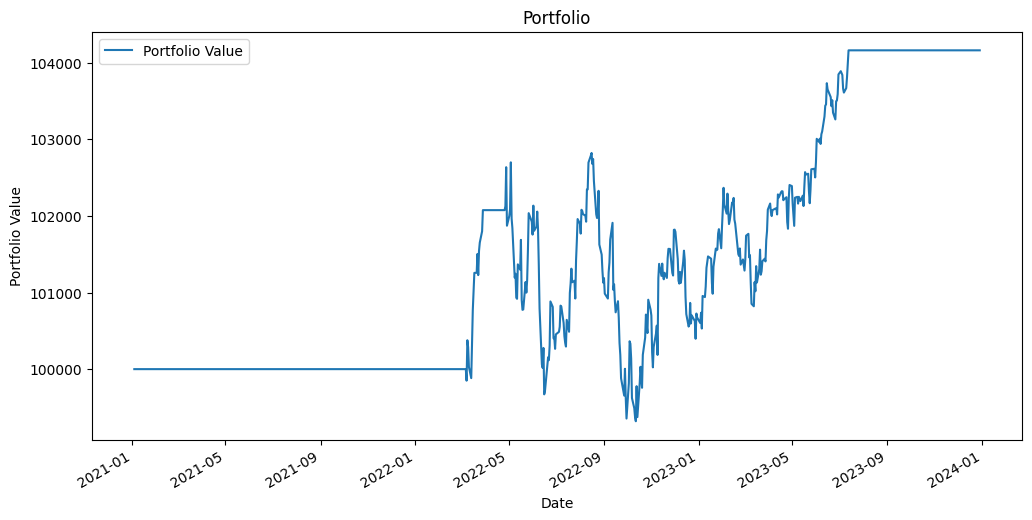

In [127]:
portfolio_df.plot(figsize=(12, 6))
plt.title('Portfolio')
plt.ylabel('Portfolio Value')
plt.show()

In [128]:
initial_value = portfolio_df['Portfolio Value'].iloc[0]
final_value = portfolio_df['Portfolio Value'].iloc[-1]
total_return = (final_value - initial_value) / initial_value * 100
print(f"Total Return: {total_return:.2f}%")

Total Return: 4.16%


In [129]:
def buy_and_hold(prices, initial_capital=100000):
    # Get the first and last dates
    start_date = prices.index[0]
    end_date = prices.index[-1]
    
    # Get the starting prices
    starting_prices = prices.loc[start_date]
    
    # Calculate the number of shares bought for each stock
    num_stocks = len(stocks)
    amount_per_stock = initial_capital / num_stocks
    shares = {stock: amount_per_stock / starting_prices[stock] for stock in stocks}
    
    # Calculate the portfolio value over time
    portfolio_values = []
    for date in prices.index:
        total_value = sum(shares[stock] * prices.loc[date, stock] for stock in stocks)
        portfolio_values.append(total_value)
    
    # Create a DataFrame for portfolio value over time
    portfolio_df = pd.DataFrame({'Date': prices.index, 'Portfolio Value': portfolio_values})
    portfolio_df.set_index('Date', inplace=True)
    return portfolio_df

In [130]:
buy_hold_df = buy_and_hold(prices)

In [131]:
initial_value_bh = buy_hold_df['Portfolio Value'].iloc[0]
final_value_bh = buy_hold_df['Portfolio Value'].iloc[-1]
total_return_bh = (final_value_bh - initial_value_bh) / initial_value_bh * 100
print(f"Buy-and-Hold Total Return: {total_return_bh:.2f}%")

Buy-and-Hold Total Return: 34.96%


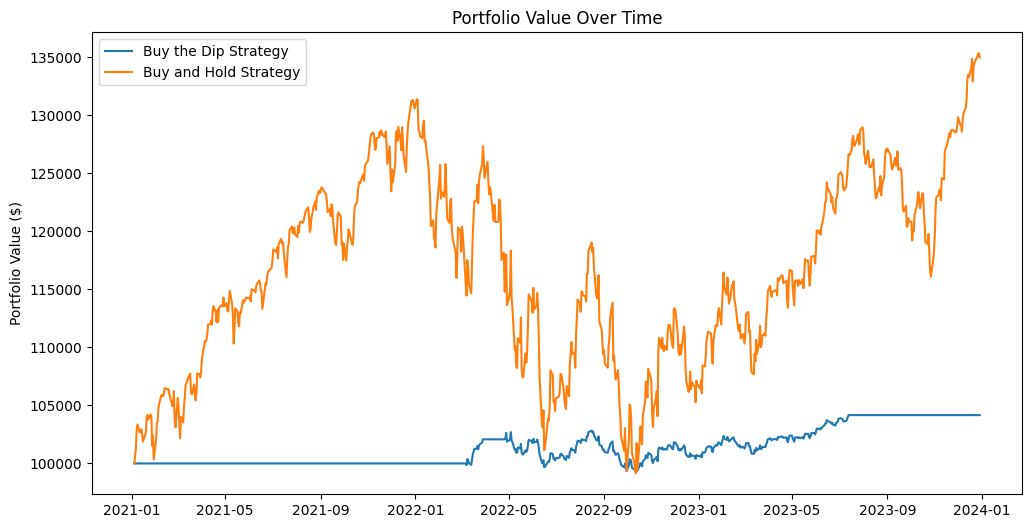

In [132]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df.index, portfolio_df['Portfolio Value'], label='Buy the Dip Strategy')
plt.plot(buy_hold_df.index, buy_hold_df['Portfolio Value'], label='Buy and Hold Strategy')
plt.title('Portfolio Value Over Time')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()